## MLPP Building a Pipeline

### Summary of Analysis
In this assignment, I examine the problem of credit delinquency using  a modified kaggle dataset. I start with some data exploration, looking for outliers and collinearities among the various features. I found that debt ratio and monthly income had many extreme values, which I rescaled in the feature engineering process. Additionally, I created bins for the age and income variables to see if there was a pattern in deliqunecy based on tier. I fit a logisitc regression model and used precision and recall for evaluation, but found that the models did not perform better than predicting no delinquencies in the data. It will be useful in the future to try multiple classification models and tweak the hyperparameters to find a better balance between true postive and false negative rates.


#### Exploration

In [1]:
from explore import *
from preprocess import *
from evaluate import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
sns.set(style='darkgrid')

Read data from csv file

In [2]:
df = read_from_csv('data/credit-data.csv', index='PersonID')

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


Check the number of null values for each column

In [4]:
count_nulls(df)

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
zipcode                                    0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           7974
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      1037
dtype: int64

Visualize collinearities between columns

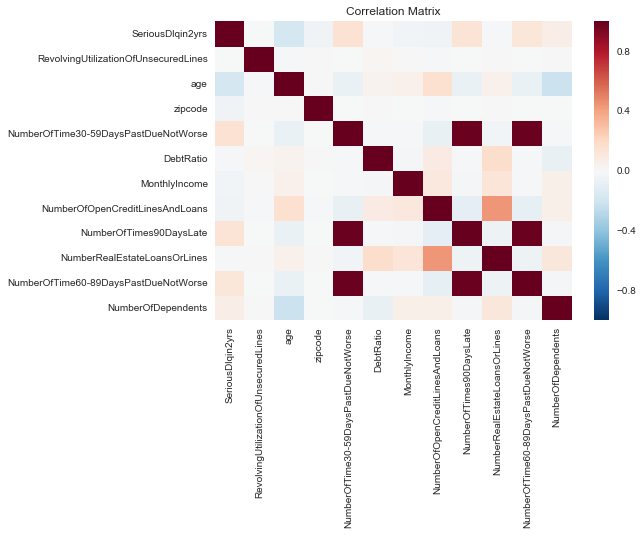

In [5]:
plot_correlations(df, 'Correlation Matrix')

Visualize distirbutions of columns

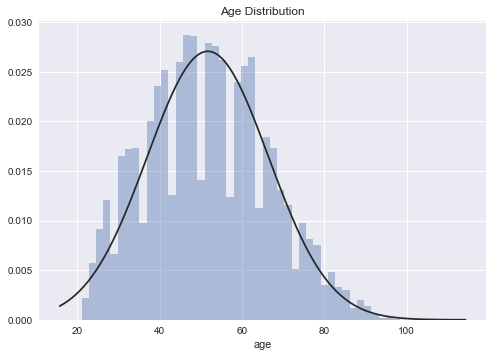

In [6]:
plot_dist(df, 'age', 'Age Distribution')

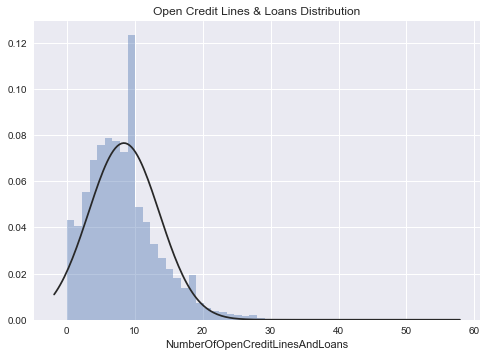

In [7]:
plot_dist(df, 'NumberOfOpenCreditLinesAndLoans', 'Open Credit Lines & Loans Distribution')

Focusing on high debt ratios

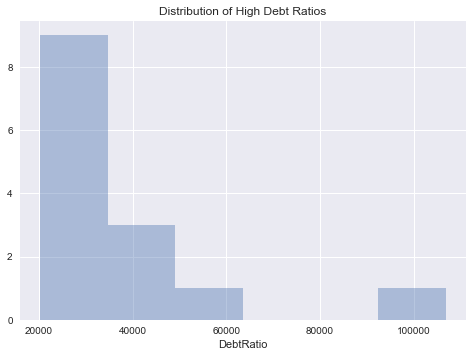

In [8]:
high_debt = df[df['DebtRatio'] > 20000]
plot_dist(high_debt, 'DebtRatio', 'Distribution of High Debt Ratios', normal=False)

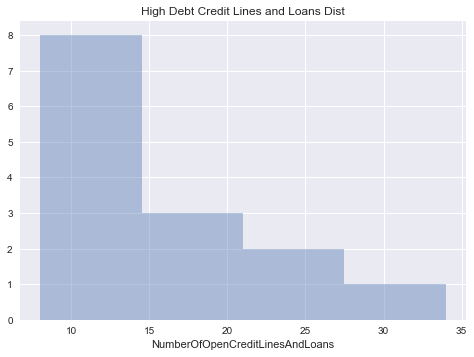

In [9]:
plot_dist(high_debt, 'NumberOfOpenCreditLinesAndLoans', 'High Debt Credit Lines and Loans Dist', normal=False)

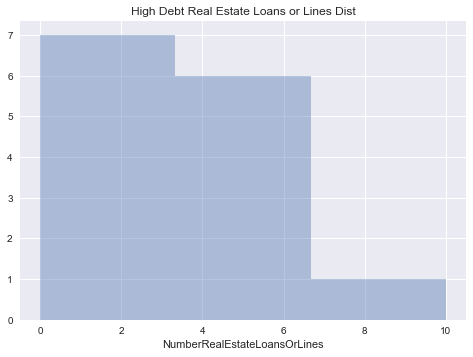

In [10]:
plot_dist(high_debt, 'NumberRealEstateLoansOrLines', 'High Debt Real Estate Loans or Lines Dist', normal=False)

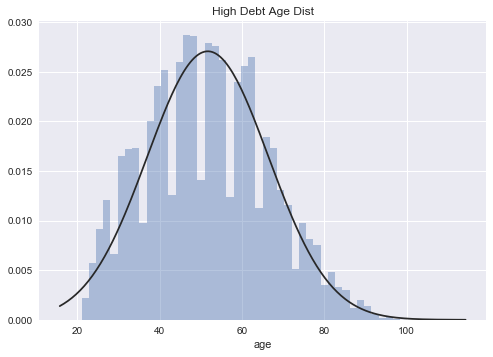

In [11]:
plot_dist(df, 'age', 'High Debt Age Dist', normal=True)

In [12]:
hd_real_estate = high_debt['NumberRealEstateLoansOrLines'].mean()
not_high_debt = df[df['DebtRatio'] <= 20000]
print('Mean number of real estate loans:', not_high_debt['NumberRealEstateLoansOrLines'].mean())
print('Mean number of real estate loans for high debt ratios:', hd_real_estate)

Mean number of real estate loans: 1.0081215550460954
Mean number of real estate loans for high debt ratios: 3.0


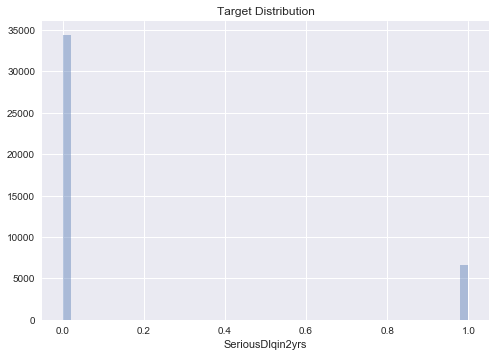

In [13]:
plot_dist(df, 'SeriousDlqin2yrs', 'Target Distribution', normal=False)

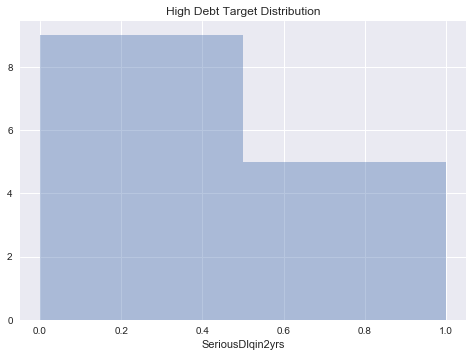

In [14]:
plot_dist(high_debt, 'SeriousDlqin2yrs', 'High Debt Target Distribution', normal=False)

#### Preprocessing & Cleaning

First, I create bins for the age and income columns and then dummify those bins. Then I make the train-test splits using `SeriousDlqin2yrs` as the target variable. From above, we saw monthly income and number of dependents had many null values, but they were not very correlated with the target variable. I imputed the missing values using means, but it may be worth checking if using median or mode for imputation changes the outcome of the classification model. The last preprocessing step was scaling the income and debt ratio columns because of their distorted distributions using the `RobustScaler` method, which removes the median and scales the data using the quantile range.

In [15]:
# bin age
df = make_bins(df, 'age', 12)

In [16]:
# bin incomes
df = make_bins(df, 'MonthlyIncome', 15)

In [17]:
# discretization
df = categorical_dummies(df, ['MonthlyIncome_bin', 'age_bin'])

In [18]:
X = df.drop(['SeriousDlqin2yrs','age_bin', 'MonthlyIncome_bin'], axis=1)
y = df['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

In [19]:
# imputation by mean values
X_train = impute_by(X_train, 'mean')
X_test = impute_by(X_test, 'mean')

In [20]:
# scale monthly income and debt ratio columns
X_train, X_test = scale_cols(X_train, X_test, 'MonthlyIncome')
X_train, X_test = scale_cols(X_train, X_test, 'DebtRatio')

#### Fitting the Model

First, I drop the columns that were binned/dummified or scaled. Then I fit a logisitic regression model and evalute the model using precison and recall metrics. 

In [21]:
drop_features = ['age', 'zipcode', 'MonthlyIncome_bin_is_nan', 'age_bin_is_nan', 'MonthlyIncome', 'DebtRatio']

In [22]:
X_train = X_train.drop(columns=drop_features, axis=1)
X_test = X_test.drop(columns=drop_features, axis=1)

In [23]:
lr1 = LogisticRegression(penalty='l2', C=0.01)
lr2 = LogisticRegression(penalty='l2', C=1.0)

lr1.fit(X_train, y_train)
y_pred1 = lr1.predict_proba(X_test)

lr2.fit(X_train, y_train)
y_pred2 = lr2.predict_proba(X_test)

In [24]:
y_pred1_bool = [int(y >= 0.65) for x,y in y_pred1]
y_pred2_bool = [int(y >= 0.65) for x,y in y_pred2]

#### Model Evaluation

After fitting a logistic regression model using different pentaly functions and different regularization strengths, which is a reasonable model for a classification problem like this. 

The accuracy of the models were around 85 percent but the baseline of the target variable is around 93 percent, so the models actually perform worse than predicting no delinquency.

The precision was 85 percent, which is suspiciously high. This is likely due to setting the positive threshold too high, meaning the model predicted lots of false positives, which is a shortcoming of this model. 

On the other hand, the recall of around 99.6 percent supports the goal of accurately identifying potentially delinquent people and support them through some sort of policy initiative. However, there could also be a high number of false negatives based on the classificaiton threshold. 

Confusion matrix, without normalization
[[11371    39]
 [ 1987   139]]


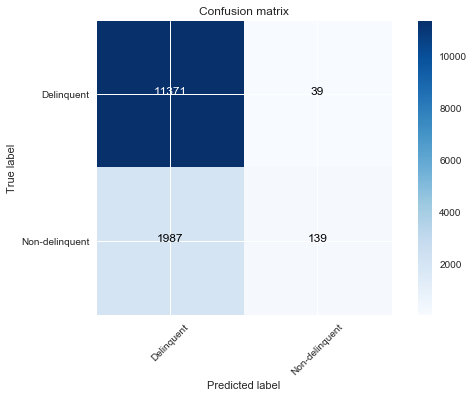

In [25]:
# Compute confusion matrix
cnf_matrix1 = confusion_matrix(y_test, y_pred1_bool)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pl.figure()
plot_confusion_matrix(cnf_matrix1, classes=['Delinquent', 'Non-delinquent'],
                      title='Confusion matrix')

In [26]:
get_precision(cnf_matrix1)

0.8512501871537655

In [27]:
get_recall(cnf_matrix1)

0.9965819456617002

In [28]:
accuracy_score(y_test, y_pred1_bool)

0.8503250591016549

Confusion matrix, without normalization
[[11368    42]
 [ 1967   159]]


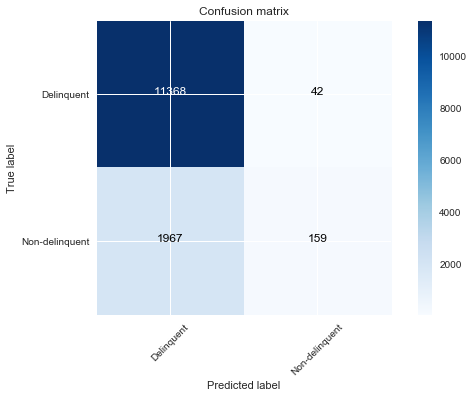

In [29]:
# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y_test, y_pred2_bool)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pl.figure()
plot_confusion_matrix(cnf_matrix2, classes=['Delinquent', 'Non-delinquent'],
                      title='Confusion matrix')

In [30]:
get_precision(cnf_matrix2)

0.85249343832021

In [31]:
get_recall(cnf_matrix2)

0.996319018404908

In [32]:
accuracy_score(y_test, y_pred2_bool)

0.8515809692671394